**2. Working with ensemble data**

Using ensemble data to practice running loops. Using "HadSST.4.0.0.0_ensemble.zip" from https://www.metoffice.gov.uk/hadobs/hadsst4/data/download.html

Also Panoply (Nasa) https://www.giss.nasa.gov/tools/panoply/ 

Steps
1. Create a for loop which loops through the files in the ensemble foler and loads each sst file and the variables

2. Within the for loop calculate the baseline, current climates and anomalies for each of the files 

3. For each type of climate: baselines, currents and anomalies, concatenate the arrays so you end up with three arrays of shape (200,36,72) (200 files, so 200 values for each grid point) 

4. Outside of the for loop calculate the anomaly mean (for each grid point)

5. Loop through all grid points and compare the distributions of the baseline compared to the currents - are they significantly different?




In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
from netCDF4 import Dataset,num2date
from datetime import date, timedelta

**Loop through the files in the ensemble folder, and load each sst file and the variables, and calculate the baseline, current climates, and anomalies for each of the files.**

In [10]:
# Setting up variables (outside of loop)
example = Dataset('/Users/bendixon/Documents/HadSST/HadSST.4.0.0.0_ensemble_member_1.nc')

# time and lat and lon are global variables
lat = example.variables['latitude'][:]
lon = example.variables['longitude'][:]

# time 
time = example.variables['time'][:]
time_units = example.variables['time'].units
calendar = example.variables['time'].calendar # I think Gregorian might be the default, not sure if needed
time_convert = num2date(time, time_units, calendar)
i_1950 = 1200; i_1980 = 1569; i_2000 = 1800; i_2018 = 2027    

In [4]:
def baseline(fn):
    # Opening the file and loading the temperature value
    swta = Dataset(fn).variables['tos'][:]
    swta = np.ma.masked_values(swta, 9.969209968386869e+36)
    # Setting the time parameters () 
    baseline = swta[i_1950:i_1980,:,:]
    baseline = np.mean(baseline,axis=0) 
    return baseline # Returning the baseline value from the loop

In [5]:
def current(fn):
    # Opening the file and loading the temperature value
    swta = Dataset(fn).variables['tos'][:]
    swta = np.ma.masked_values(swta, 9.969209968386869e+36)
    # Setting the time parameters () 
    current = swta[i_2000:i_2018,:,:]
    current = np.mean(current,axis=0)
    return current # Returning the baseline value from the loop

*Potential improvements*

* Merge baseline and current files to do mean(start_date,end_date) so no need for individual functions
* Also work out how to go from start and end date in DD-MM-YYYY to the position in the array

In [6]:
# Initialise the arrays 
bas_a = np.zeros((1,36,72)) 
cur_a = np.zeros((1,36,72))

directory = '/Users/bendixon/Documents/HadSST/'
os.chdir('/Users/bendixon/Documents/HadSST/') # do we need to do both of these?
# looping through the models, working out the baseline
for filename in os.listdir(directory):
    bas = np.array([baseline(filename)]) 
    bas_b = np.concatenate((bas,bas_a),axis=0)
    bas_a = bas_b # Maybe there's a better way of doing this another loop
print(bas_b.shape)
# looping through the models, working out the current value
for filename in os.listdir(directory):
    cur = np.array([current(filename)])
    cur_b = np.concatenate((cur,cur_a),axis=0)
    cur_a = cur_b
print(cur_b.shape)
# Is there a better way using loops rather than setting cur_a = cur_b at the end?

(201, 36, 72)
(201, 36, 72)


In [7]:
anom_a = np.zeros((201,36,72))
anom_a = np.subtract(cur_b,bas_b)
print(anom_a.shape)

(201, 36, 72)


In [8]:
# Are these values statistically significant?
# Comparing 
statistic = []
significance = [] # I tried this with a 36 by 72 array but couldnt get the loop to insert in the right places

from scipy.stats import ks_2samp # Kolmogorov-Smirnov statistic on two samples

for i in range(36):
    m = []
    for j in range(72):
        s = ks_2samp(bas_b[:,i,j],cur_b[:,i,j]).statistic
        s = float(s)
        statistic.append(s)
        p = ks_2samp(bas_b[:,i,j],cur_b[:,i,j]).pvalue
        if p < 0.01:
            significance.append(True)
        else:
            significance.append(False)
        
statistic = np.reshape(statistic,(36,72)) # putting this into a nice array 
significance = np.reshape(significance,(36,72)) # putting this into a nice array

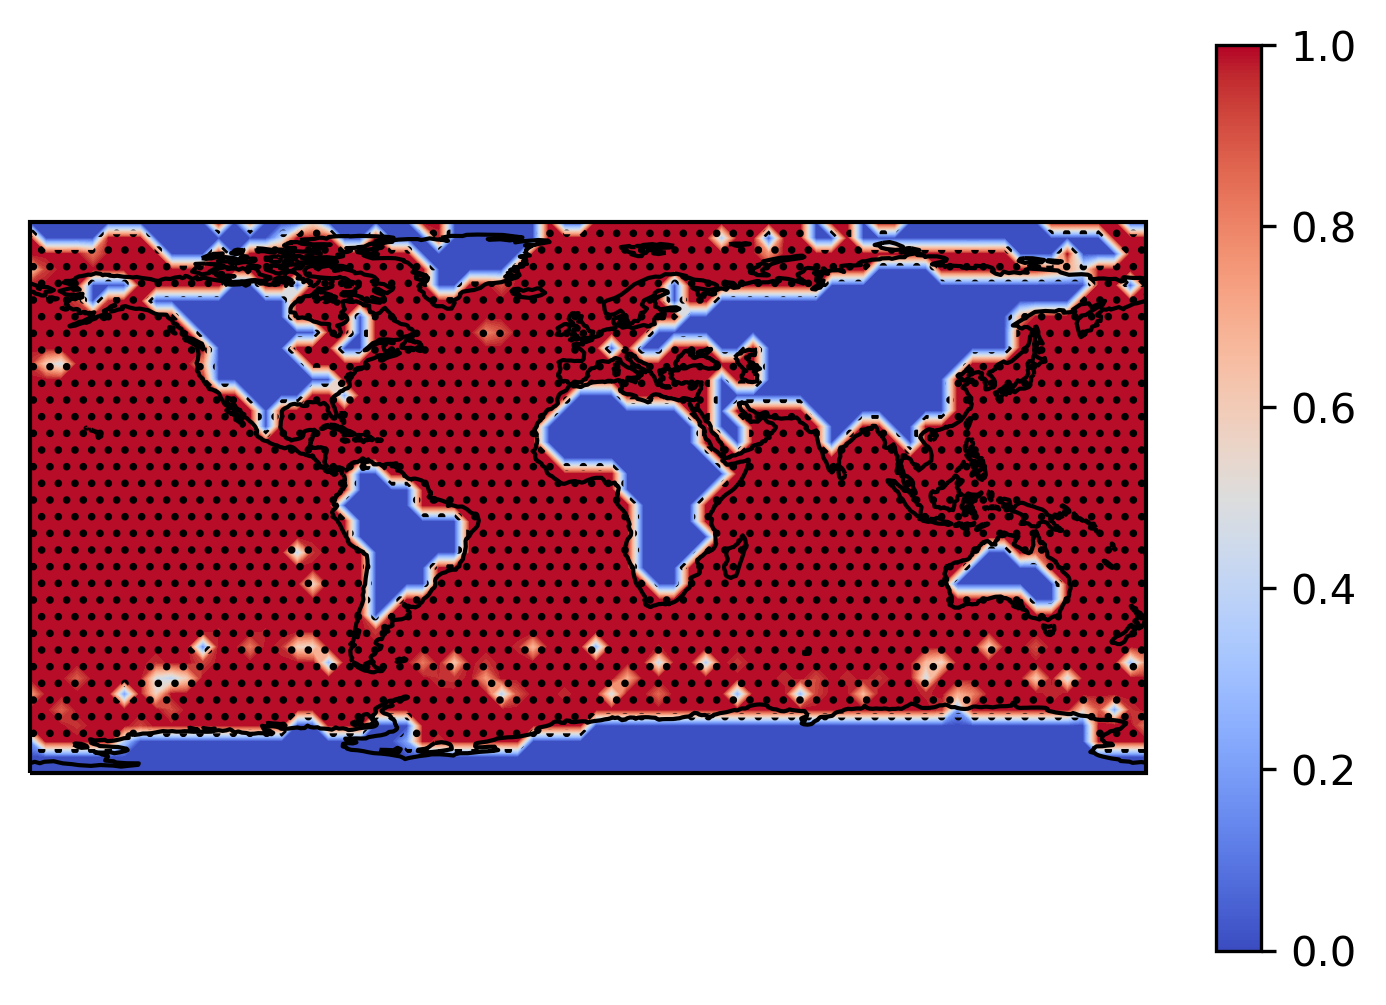

In [14]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
ax = plt.axes(projection=ccrs.PlateCarree())

# add the contour layer to the axes, the points will need to be tranformed to the map projection
ax.contourf(lon, lat,statistic, 60, transform=ccrs.PlateCarree(),cmap='coolwarm')
ax.contourf(lon,lat,significance,3,colors='none',hatches=['','...'],transform=ccrs.PlateCarree())
ax.coastlines()

# add a colourbar
cbar = plt.cm.ScalarMappable(cmap='coolwarm',norm=plt.Normalize(0,1))
plt.colorbar(cbar,ax=ax)

plt.show()

## Workings/ideas

In [ ]:
# print current working directory
os.getcwd()

In [ ]:
# old function definition, in case needed later
def anomaly(fn):
    # Opening the file and loading the temperature value
    swta_file = Dataset(fn)
    variables = swta_file.variables
    swta = swta_file.variables['tos'][:]
    swta = np.ma.masked_values(swta, 9.969209968386869e+36)
    # Setting the time parameters () 
    baseline = swta[i_1950:i_1980,:,:]
    baseline = np.mean(baseline,axis=0) 
    current = swta[i_2000:i_2018,:,:]
    current = np.mean(current,axis=0)
    # Printing the anomaly
    anom = current - baseline
    anom = np.array(anom, dtype=float)
    return anom

In [ ]:
print(time_convert[1200])
print(time_convert[1560]) # not sure why some months there are measurements at 00:00 or 12:00
print(time_convert[1800])
print(time_convert[2027]) # this is only up to 2018, but that's the size of the array